# Ultimate Technologies Inc. Take-Home Challenge

## Imports

In [35]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.style.use(['ggplot'])

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score

# Hypermeter tuning packages
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

import pickle

<div class="alert alert-info">
    
## Part 1 ‐ Exploratory data analysis

Aggregate these login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.
    
</div>
    
    

In [2]:
# The file contains (simulated) timestamps of user logins in a particular geographic location. 
# Load the json file
df = pd.read_json('logins.json')
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
print(f'Shape of dataframe {df.shape}')
print('Type of column')
df.dtypes

Shape of dataframe (93142, 1)
Type of column


login_time    datetime64[ns]
dtype: object

In [4]:
# Print first and last login data
print(f'First login: {min(df.login_time)}')
print(f'Last login: {max(df.login_time)}')

First login: 1970-01-01 20:12:16
Last login: 1970-04-13 18:57:38


In [5]:
# Create a new column for counts
df['count'] = 1

In [6]:
# Create 15 minutes intervals
df = pd.DataFrame(df.groupby([pd.Grouper(key='login_time', freq='15Min')]).sum()).reset_index()
df.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [7]:
# Extract the week 
df['week'] = df.login_time.dt.isocalendar().week

# Exctract the day
df['cal_day'] = df.login_time.dt.date

# Extract the day as a new columns
df['day'] = df.login_time.dt.dayofweek  # 0 is Monday and 6 is Sunday

# Show the day is weekday or weekend
df['weekday'] = np.where(df.day.isin([5,6]), 0, 1) #1 = WEEKDAY and 0 = WEEKEND

# Extract time
df['time'] = df['login_time'].dt.time

# Extract the hour
df['hour'] = df.login_time.dt.hour

df.head()

,login_time,count,week,cal_day,day,weekday,time,hour
0,1970-01-01 20:00:00,2,1,1970-01-01,3,1,20:00:00,20
1,1970-01-01 20:15:00,6,1,1970-01-01,3,1,20:15:00,20
2,1970-01-01 20:30:00,9,1,1970-01-01,3,1,20:30:00,20
3,1970-01-01 20:45:00,7,1,1970-01-01,3,1,20:45:00,20
4,1970-01-01 21:00:00,1,1,1970-01-01,3,1,21:00:00,21


<div class="alert alert-warning">
    
## Visualization of Demand
<div>

### *Daily demand change*

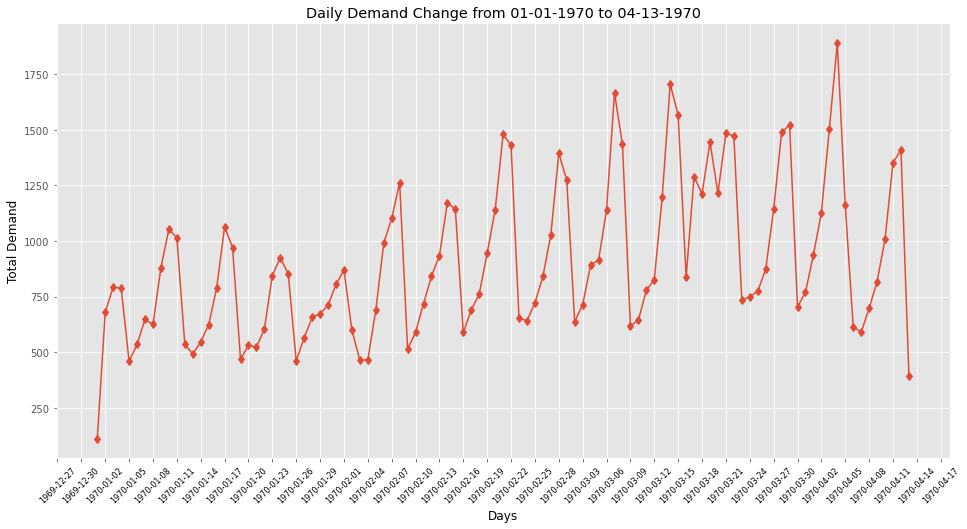

In [8]:
plt.figure(figsize=(16,8))
# plot
df.groupby('cal_day').sum()['count'].plot.line(marker ='d')
# customize
plt.title('Daily Demand Change from 01-01-1970 to 04-13-1970')
plt.xlabel("Days", color='black')
plt.ylabel('Total Demand',color='black')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=3))
plt.xticks(rotation=45, color='black', fontsize=8 )
plt.show()

<div class="alert alert-success">
Daily demand change shows seasonality. There are increases and decreases in a time interval, which changes between 6 and 8 days. Also, there is a slight increase in demand over time. The highest demand is at the beginning of April.
</div>

### *Demand change according to week*

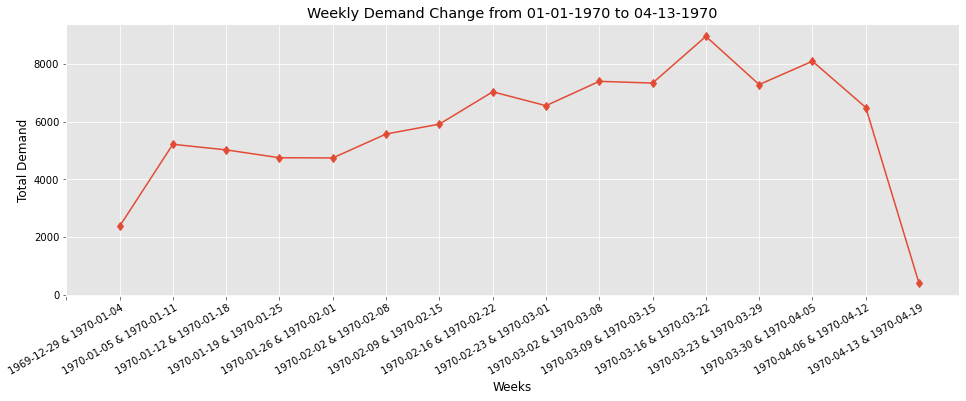

In [9]:
plt.figure(figsize=(16,5))
df.groupby('week').sum()['count'].plot.line(marker = 'd')
# Customize
plt.title('Weekly Demand Change from 01-01-1970 to 04-13-1970')
plt.xlabel("Weeks", color='black')
plt.ylabel('Total Demand',color='black')
xticks = ['1969-12-29 & 1970-01-04', '1970-01-05 & 1970-01-11','1970-01-12 & 1970-01-18',
          '1970-01-19 & 1970-01-25', '1970-01-26 & 1970-02-01', '1970-02-02 & 1970-02-08',
          '1970-02-09 & 1970-02-15', '1970-02-16 & 1970-02-22', '1970-02-23 & 1970-03-01',
          '1970-03-02 & 1970-03-08', '1970-03-09 & 1970-03-15', '1970-03-16 & 1970-03-22',
          '1970-03-23 & 1970-03-29', '1970-03-30 & 1970-04-05', '1970-04-06 & 1970-04-12',
          '1970-04-13 & 1970-04-19']
        
plt.xticks(np.arange(0,16), xticks, rotation=30, color='black')
plt.yticks(color='black')
plt.show()
plt.show()

<div class="alert alert-success">
The increase in demand is seen more easily. The first and last week have lower demand than the others. These weeks only include a couple of days, not all days. For example, there are no logins after April 13th; last week includes only that day. Therefore, there could be some bias. Average demand is at its highest in the 3rd week of March. <div>

### *Demand change during the day*

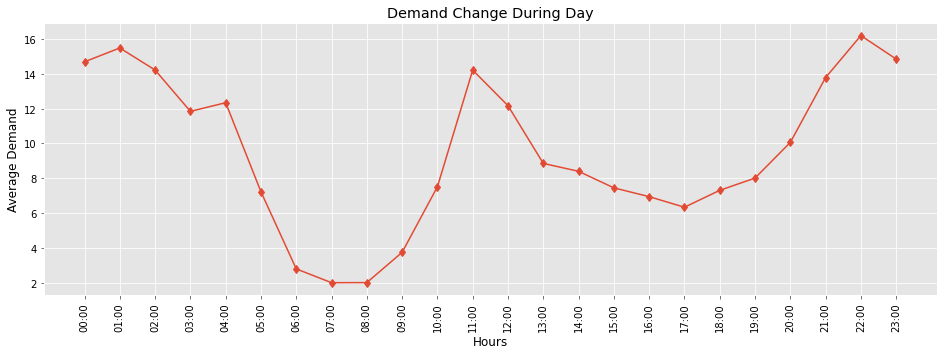

In [10]:
plt.figure(figsize=(16,5))
# plot
df.groupby('hour').mean()['count'].plot.line(marker='d')
# Customize
plt.title('Demand Change During Day')
plt.xlabel("Hours", color='black')
plt.ylabel('Average Demand',color='black')
xticks = ['00:00', '01:00', '02:00', '03:00','04:00','05:00','06:00','07:00',
          '08:00','09:00','10:00','11:00','12:00','13:00','14:00','15:00',
          '16:00','17:00','18:00','19:00','20:00','21:00','22:00','23:00']
plt.xticks(np.arange(0,24), xticks, rotation=90, color='black')
plt.yticks(color='black')
plt.show()

<div class="alert alert-success"> The busiest hours during the day are midnight and noon. Between 6:00 and 9:00, there is rather few demand. <div>

### *Demand change according to week days*

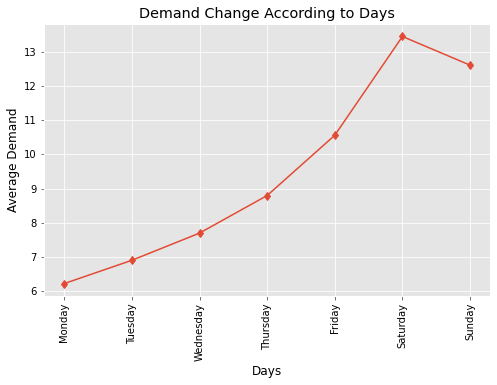

In [11]:
plt.figure(figsize=(8,5))
# plot
df.groupby('day').mean()['count'].plot.line(marker='d')
# Customize
plt.title('Demand Change According to Days')
plt.xlabel("Days", color='black')
plt.ylabel('Average Demand',color='black')
plt.xticks([0, 1, 2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
       rotation=90, color='black')
plt.yticks(color='black')
plt.show()

<div class="alert alert-success"> In weekends, there is a really high demand. The highest demand is on Saturday. Demand increases from Monday to Friday in weekdays. <Div>

<div class="alert alert-info">

## Part 2 ‐ Experiment and metrics design
    
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1) What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?
    
2) Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:
    
a) how you will implement the experiment
    
b) what statistical test(s) you will conduct to verify the significance of the observation
    
c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.
<div>


<div class="alert alert-success">
 
There are some assumptions in designing the experiment:

* Ultimate could track drivers' locations and determine that driver is in Gotham or Metropolis. 
* The past time range to be compared with the time range in which the experiment was conducted is similar. For instance, there are no holidays in these periods.
* During day: From 07:00 am to 7:00 pm
  Night: From 10:00 pm to 3:00 am
    
**Experiment Design**
 
Our metric is the number of drivers day and night on weekdays in Gotham and Metropolis. Reimbursing all toll costs is our intervention tool, and we try to explain this effect. The experiment will last for two weeks. 
    Pre-data: The number of drivers in two weeks (daytime/night) before starting to reimburse.
    Post-data: The number of drivers in two weeks (daytime/night) that Ultimate reimburses the toll costs.

The table below is an example of data on Gotham in the daytime. The same will gather for Gothom night, Metropolis day, and Metropolis night.
    
| Days | Pre| Post |
| --- | --- | --- |
| Monday| X1 | X2 |  
| Tuesday | X3 | X4 |
| Wednesday | X5 | X6 |
| Thursday | X7 | X8 |
| Friday | X9 | X10 |

    
H0: There is no difference in the number of cars in Gotham on weekdays (daytime) for two weeks before and after Ultimate offers reimbursements.
    
H1: There is an increase in the number of cars in Gotham on weekdays (daytime) after Ultimate offers reimbursements.
  
The hypothesis for Gothom Gothom night, Metropolis day, and Metropolis night will be adapted from H0 and H1. 
    
The observation number is 10 (less than 30); therefore, the non-parametric test will be used. The number of cars will be compared by e Wilcoxon test. If p is less than .05, we will reject the H0, which means the experiment affects driver-partners to tend to be exclusive to each city.

If required, the experiment can be carried out for a longer time. Increasing the number of observations could cause a change in the statistical test. If the number of observations is greater than 30 and shows a normal distribution, the dependent paired t-test can be used.
    

 

<div class="alert alert-info">
    
## Part 3 ‐ Predictive modeling


Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
    
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
  

<div class="alert alert-warning">
    
## Data Wrangling

In [12]:
# Load the json file
df_2 = pd.read_json('ultimate_data_challenge.json')

In [13]:
df_2.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [14]:
df_2.shape

(50000, 12)

**Note:** There are 50,000 users' data in the dataframe. We assume that each row belongs to a unique user.

In [15]:
df_2.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [16]:
# Convert boolean to 1-0
df_2['ultimate_black_user'] = df_2['ultimate_black_user'].astype(int)

In [17]:
# See how many different cities
df_2.city.value_counts()

Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64

In [299]:
# See nulls
df_2.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

***Labeling users as retained or not***

<div class="alert alert-info">

**Retained User:** If a user was “active” (i.e. took a trip) in the preceding 30 days, the user was labeled as retained.
<div>

In [18]:
# Convert to datetime two columns
df_2['signup_date'] = pd.to_datetime(df_2['signup_date'])
df_2['last_trip_date'] = pd.to_datetime(df_2['last_trip_date'])

In [19]:
# Find the recent last_trip_date
max(df_2['last_trip_date'])

Timestamp('2014-07-01 00:00:00')

<div class="alert alert-success">

**Note:** Users' last trip is on 07-01-2014. We will examine whether they took trips between 06-01-2014 and 07-01-2014 to determine if they are retained users.

In [20]:
df_2['label'] = np.where(df_2['last_trip_date']<'2014-06-01 00:00:00', 0,1)

In [21]:
df_2['label'].value_counts(normalize=True)

0    0.62392
1    0.37608
Name: label, dtype: float64

<div class="alert alert-success">
    
**Note:** 37.6% of users are retained.
<div>

<div class="alert alert-warning">
    
### EDA
<div>

***Descriptive statistics of features according to user label***

In [22]:
# describe() function for label == 0 and label == 1
# concat two dfs
stats = pd.concat([df_2[df_2['label']==0].describe().T, df_2[df_2['label']==1].describe().T], axis=0)
# To be clear, show which rows related to which label
stats['label'] = [0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1]

stats[['label', 'count','mean','std','min','25%','50%','75%','max']]


,label,count,mean,std,min,25%,50%,75%,max
trips_in_first_30_days,0,31196.0,1.658482,2.654222,0.0,0.00,1.00,2.00,73.00
avg_rating_of_driver,0,24706.0,4.607557,0.664418,1.0,4.40,5.00,5.00,5.00
avg_surge,0,31196.0,1.075339,0.251361,1.0,1.00,1.00,1.00,8.00
surge_pct,0,31196.0,8.666739,22.179139,0.0,0.00,0.00,0.00,100.00
ultimate_black_user,0,31196.0,0.299942,0.458240,0.0,0.00,0.00,1.00,1.00
weekday_pct,0,31196.0,60.647032,40.982688,0.0,16.70,69.60,100.00,100.00
avg_dist,0,31196.0,6.207939,6.238675,0.0,2.32,4.03,7.80,129.89
avg_rating_by_driver,0,31031.0,4.787464,0.504648,1.0,4.80,5.00,5.00,5.00
label,0,31196.0,0.000000,0.000000,0.0,0.00,0.00,0.00,0.00
trips_in_first_30_days,1,18804.0,3.306318,4.986743,0.0,0.00,2.00,4.00,125.00


<div class="alert alert-success">
    
**Note:** "weekday_pct" feature has higher average than other features. "surge_pct" has high standart deviation that shows that data are more spread out.
<div>

***Distribution of users according to city***

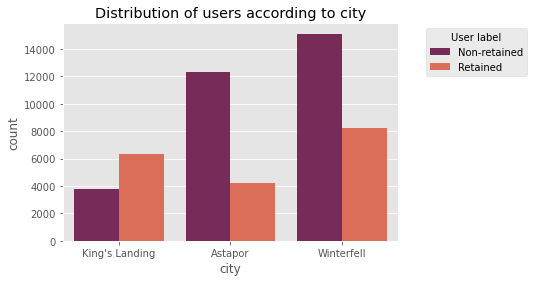

In [23]:
g = sns.countplot(x = 'city', data=df_2, hue='label', palette="rocket")
g.set(title = 'Distribution of users according to city')
plt.legend(title='User label', loc='upper right', bbox_to_anchor=(1.4, 1), labels=['Non-retained', 'Retained'])
plt.show()

<div class="alert alert-success">
    
**Note:** Whereas the most of the users are from Winterfell, the least users are from King's Landing. In Astapor and Winterfell the retained users more than the others. 
<div>

***Distribution of users by whether they took Ultimate Black***

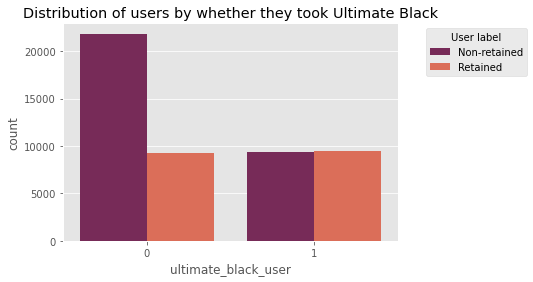

In [24]:
g = sns.countplot(x = 'ultimate_black_user', data=df_2, hue='label', palette="rocket")
g.set(title = 'Distribution of users by whether they took Ultimate Black')
plt.legend(title='User label', loc='upper right', bbox_to_anchor=(1.4, 1), labels=['Non-retained', 'Retained'])
plt.show()

<div class="alert alert-success">
    
**Note:** Approximately half of the retained users have taken Ultimate Black  in the first 30 days after signing up. The trend for non-retained users is not to use Ultimate Black in their first month.

<div>

***Distribution of the percent of the user’s trips occurring during a weekday***

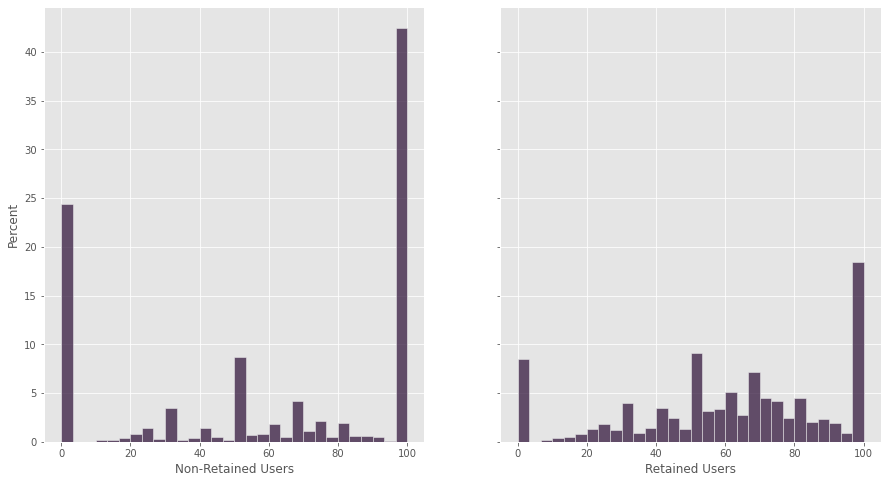

In [25]:
# Histogram of percentages
sns.set_palette("rocket")
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,8))

sns.histplot(df_2[df_2['label']==0]['weekday_pct'],
             stat = 'percent', ax=ax0, bins=30)
sns.histplot(df_2[df_2['label']==1]['weekday_pct'],
             stat = 'percent', ax=ax1, bins=30)
ax0.set(xlabel='Non-Retained Users')
ax1.set(xlabel='Retained Users')
plt.show()

<div class="alert alert-success">
    
**Note:** More than 40% of non-retained users have taken all their trips on weekdays, whereas about 25% of them used Ultimate only on weekends. For retained users, the distribution seems close to normal, except for those who took a trip only on weekends/weekdays. Of the retained users' less than 20% use Ultimate only on weekdays.

<div>

***Distribution of users according to their number of trips in the first 30 days***

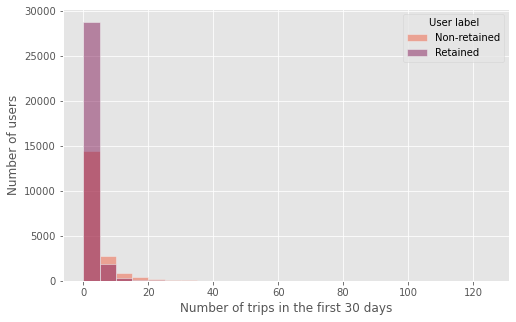

In [26]:
plt.figure(figsize=(8,5))
sns.histplot(data = df_2, x= 'trips_in_first_30_days', bins=25,
             hue='label',palette="rocket")
plt.legend(title='User label', loc='upper right', labels=['Non-retained', 'Retained'])
plt.xlabel('Number of trips in the first 30 days')
plt.ylabel('Number of users')
plt.show()

<div class="alert alert-success">
    
**Note:** Non-Retained users mostly used 5 or less times in their first month after signup to Ultimate. Retained users used the Ultimate for more than 5 days than non-retained users.

<div>

***Distribution of users according to average distance per trips in the first 30 days***

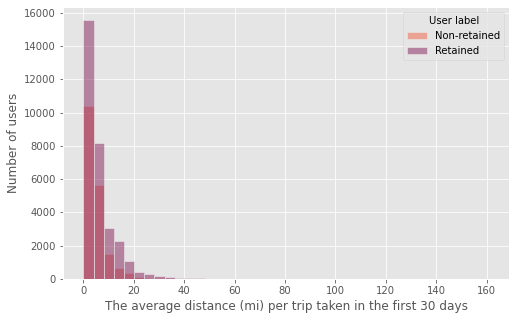

In [27]:
plt.figure(figsize=(8,5))
g = sns.histplot(data = df_2, x= 'avg_dist', bins=40,
             hue='label',palette='rocket')
plt.legend(title='User label', loc='upper right', labels=['Non-retained', 'Retained'])
plt.xlabel('The average distance (mi) per trip taken in the first 30 days')
plt.ylabel('Number of users')
plt.show()


<div class="alert alert-success">
    
**Note:** Retained users used Ultimate for longer distances in the first 30 days after signup.

<div>

<div class="alert alert-info">
    
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance. <div>

<div class="alert alert-success">
    
**Note:** I will use XGBoost model. XGBoost is a decision-tree-based ensemble Machine Learning algorithm that uses a gradient boosting framework. 

* One of the advantage of XGBoost is that it supports missing values by default. There are several nulls in "avg_rating_of_driver","phone" and" avg_rating_by_driver" features.

* XGBoost consists of a number of hyper-parameters that can be tuned — a primary advantage over gradient boosting machines.
    
* Memory efficient and fast.
    
    
 There are some requirements for XGBoost to achieve top performance. Mainly:

- Numeric features should be scaled.
    
- Categorical features should be encoded.
    


In [29]:
# The datetime columns won't be used in model. Drop them.
df_2.drop(columns=['signup_date','last_trip_date'], inplace=True)

***Split the train and test data***

In [30]:
# Define X as model input data and y as review labels.

y = df_2['label'] # Target
X = df_2.drop(columns = 'label') # Features

# Split data as train-test 
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20,random_state=53)

In [31]:
# Check the shapes
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (40000, 10)
X_test: (10000, 10)
y_train: (40000,)
y_test: (10000,)


***Encode categorical variables***

There are two features which are categorical: 
* city of users: There are three cities.
* phone of users: Android or Iphone

In [32]:
# Get dummies for 'city' column - TRAIN 
city_dummies = pd.get_dummies(X_train['city'], prefix='city')
X_train = pd.concat([X_train, city_dummies], axis=1)

# Get dummies for 'city' column - TEST
city_dummies = pd.get_dummies(X_test['city'], prefix='city')
X_test = pd.concat([X_test, city_dummies], axis=1)

# Drop orijinal city column
X_train.drop(columns='city', inplace=True)
X_test.drop(columns='city', inplace=True)

In [33]:
# Get dummies for 'phone' column - TRAIN 
X_train['phone'] = np.where(X_train['phone']=='iPhone',1,0)
X_test['phone'] = np.where(X_test['phone']=='iPhone',1,0)

***Build XGBoost Classifier***

In [36]:
# initiate the model
model_xgb = xgb.XGBClassifier(seed=0)  

# Scale both train and test data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit model on scaled X_train data
model_xgb.fit(X_train_scaled, y_train)

# Call predict 
y_pred = model_xgb.predict(X_test_scaled) 

In [37]:
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.7871


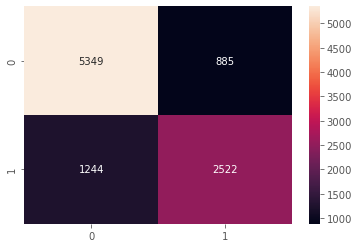

In [38]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

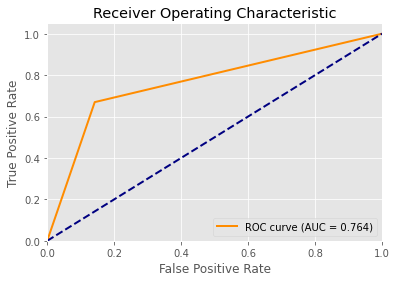

In [39]:
# Visualize the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

***Hypermeter Tuning***

In [47]:
# Define the search space
parameters = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}

# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [48]:
# Define random search
random_search = RandomizedSearchCV(estimator=model_xgb , 
                           param_distributions=parameters,
                           scoring = 'accuracy', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)

# Fit grid search
random_result = random_search.fit(X_train_scaled, y_train)

In [49]:
# Print the best score and the corresponding hyperparameters
print('Best Score: %s' % random_result.best_score_)
print(f'The best hyperparameters are {random_result.best_params_}')

Best Score: 0.7815499966020224
The best hyperparameters are {'reg_lambda': 1, 'reg_alpha': 0.1, 'max_depth': 12, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 0.9}


***Use best parameters on unseen test data***

In [50]:
random_best = random_search.best_estimator_.fit(X_train_scaled,y_train)

y_pred = random_best.predict(X_test_scaled)

In [51]:
print("Accuracy:", metrics.accuracy_score(y_test,y_pred))

Accuracy: 0.784


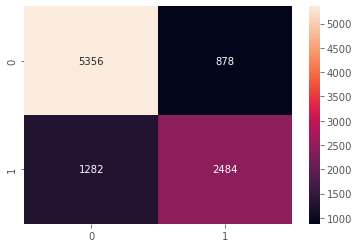

In [52]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g')
plt.show()

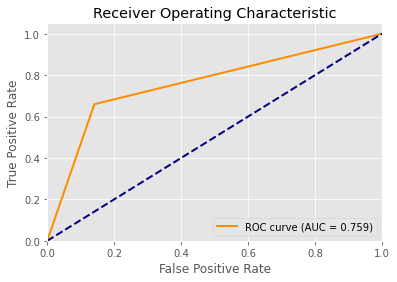

In [53]:
# Visualize the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Note:** The optimized model performs worse with the unseen test set.  Therefore, it can be said that there is a overfitting. We will use model with the default settings. 

In [68]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)
print(X.shape)
print(y.shape)

(50000, 12)
(50000,)


In [70]:
# instantiate the model
model_xgb_final = xgb.XGBClassifier(seed=0)  

# train final model with all data
model_xgb_final.fit(X, y)

# save model
pickle.dump(model_xgb_final, open('model_final.pickle', 'wb'))


***Feature Importance***

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

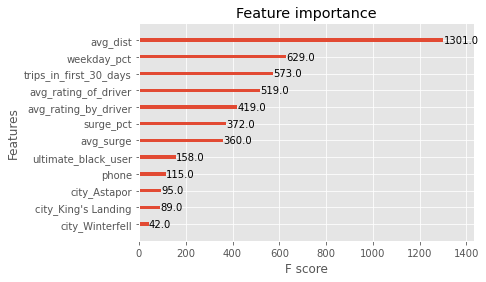

In [71]:
plot_importance(model_xgb_final)

<div class="alert alert-success">
    
We deployed XGBoost classifier with default parameters, with  classification accuracy of 78.81% and AUC score of about 76.4% for the test data. The model showed that the most important indicators of being a retained user are
    
 * The average distance in miles per trip taken in the first 30 days after signup
    
 * The percent of the user’s trips occurring during a weekday
    
 * The number of trips this user took in the first 30 days after signing up
    

<div class="alert alert-info">
    
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).

<div class="alert alert-success">

Considering the most important features that play a role in user retention, these are the insights to improve long-term user retention.
    
* Retained users have used Ultimate for longer distances. Different offers/campaigns  could be presented to non-retained users for longer distances to improve user retention.
    
* Non-retained users have taken a ride only on weekdays or weekends whereas retained users mostly have no specific difference between days. Therefore, non-retained user who use Ultimate both weekends and weekdays could be on focus.
    
* The number of trips in the first 30 days is essential in retaining. Hence after a user signup Ultimate, they would be encouraged to take more trips in the first month. 